# Install

In [ ]:
!pip3 install pshmodule

In [ ]:
!pip3 install pickle5

In [ ]:
!pip3 install pandas==1.5.0

In [ ]:
!pip3 install swifter

In [ ]:
!pip install transformers
!wget https://raw.githubusercontent.com/smilegate-ai/korean_smile_style_dataset/main/smilestyle_dataset.tsv

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Load

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/MemeProject/src/pytorch/preprocessing')
print(sys.path)

['/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/MemeProject/src/pytorch/preprocessing']


In [ ]:
from tqdm import tqdm
import config as cfg
import pandas as pd
import numpy as np
import swifter
from tqdm import tqdm
from pshmodule.utils import filemanager as fm

In [ ]:
df = fm.load(cfg.origin_class153_ref)

extension : .pickle
Loaded 181704 records from drive/MyDrive/MemeProject/data/augmentation/origin_class153_ref.pickle


In [ ]:
df_table = fm.load(cfg.report_label)

extension : .xlsx
Loaded 153 records from drive/MyDrive/MemeProject/data/report/table.xlsx


In [ ]:
df.head()

,num,g_num,u_num,material,speech,u,meme,arg1,arg_op1,arg_op2,label
0,1,1,1,학교생활,자랑,나 중간고사 반에서 1등했어,그렇다면 통 크게 함 쏴야지! 근데 이제 내 것도 곁들인...,중간고사,,,146
1,1,1,1,학교생활,자랑,나 중간고사 반에서 1등했어,그렇다면 통 크게 함 쏴야지! 근데 이제 내 몫을 제일 많이 곁들인...,중간고사,,,146
2,1,1,1,학교생활,자랑,나 중간고사 반에서 1등했어,그렇다면 통 크게 함 쏴야지! 근데 이제 대춘이 몫도 곁들인...,중간고사,,,146
3,1,1,1,학교생활,자랑,나 중간고사 반에서 1등했어,그렇다면 통 크게 함 쏴야지! 근데 이제 배보다 배꼽이 더 큰 걸 곁들인...,중간고사,,,146
4,1,1,1,학교생활,자랑,나 중간고사 반에서 1등했어,그렇다면 통 크게 함 쏴야지! 근데 이제 과소비를 곁들인...,중간고사,,,146


# Augmentation

##### replace에서 arg1(너, 대춘이),  너 너무 -> 대춘이 대춘이무 같은 상황을 방지하기 위해 앞 뒤로 공백 처리

In [ ]:
df['arg1_space'] = " " + df.arg1.values + " "

In [ ]:
df = df[['g_num', 'u_num', 'material', 'speech', 'u', 'arg1', 'arg1_space', 'label']]

In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

<ipython-input-8-bd30c309daa2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


In [ ]:
df.shape

(9150, 8)

##### 대화소재 밈봇 제거

In [ ]:
df_memebot = df[(df.label.values == 149) | (df.label.values == 150) | (df.label.values == 151) | (df.label.values == 152)]
df_remain = df[(df.label.values != 149) & (df.label.values != 150) & (df.label.values != 151) & (df.label.values != 152)]

In [ ]:
print(df_memebot.label.value_counts().shape)
print(df_remain.label.value_counts().shape)

(4,)
(149,)


In [ ]:
df_memebot.shape

(1938, 8)

In [ ]:
temp_list = []
result = []

for i in tqdm(df_remain.iterrows()):
  temp_list.append([i[1]['g_num'], i[1]['u_num'], i[1]['material'], i[1]['speech'], i[1]['u'], i[1]['arg1_space'], i[1]['label']])
  
  # group of 6
  if len(temp_list) % 6 == 0:
    temp_arg = list(set([i[5] for i in temp_list]))
    # replace arg
    for l in temp_list:
      # origin
      result.append([l[0], l[1], l[2], l[3], l[4], '', l[6]])
      
      # replacement
      if len(temp_arg) > 1:
        # 교체될 단어가 문장의 첫 어절이면 스페이스를 뒤만.
        # 교체될 단어가 문장의 첫 어절이 아니면 스페이스를 앞뒤로.
        for k, i in enumerate(temp_arg):
          temp_arg_copy = temp_arg.copy()
          temp_arg_copy.pop(k)
          for ii in temp_arg_copy:
            if l[4].find(i.strip()) == 0 and l[4] != l[4].replace(i.lstrip(), ii.lstrip()):
              result.append([l[0], l[1], l[2], l[3], l[4].replace(i.lstrip(), ii.lstrip()), ii.strip(), l[6]])
            elif l[4].find(i.strip()) > 0 and l[4] != l[4].replace(i, ii):
              result.append([l[0], l[1], l[2], l[3], l[4].replace(i, ii), ii.strip(), l[6]])
    temp_list = []

7212it [00:01, 5355.53it/s]


In [ ]:
print(f"result : {result}")

result : [[1, 1, '학교생활', '자랑', '나 중간고사 반에서 1등했어', '', 146], [1, 1, '학교생활', '자랑', '나 시험 반에서 1등했어', '시험', 146], [1, 1, '학교생활', '자랑', '나 중간 반에서 1등했어', '중간', 146], [1, 1, '학교생활', '자랑', '나 중간시험 반에서 1등했어', '중간시험', 146], [1, 2, '학교생활', '자랑', '중간고사 점수 내가 반에서 제일 잘 받음', '', 146], [1, 2, '학교생활', '자랑', '시험 점수 내가 반에서 제일 잘 받음', '시험', 146], [1, 2, '학교생활', '자랑', '중간 점수 내가 반에서 제일 잘 받음', '중간', 146], [1, 2, '학교생활', '자랑', '중간시험 점수 내가 반에서 제일 잘 받음', '중간시험', 146], [1, 3, '학교생활', '자랑', '나 반에서 중간 성적 제일 좋아', '', 146], [1, 3, '학교생활', '자랑', '나 반에서 시험 성적 제일 좋아', '시험', 146], [1, 3, '학교생활', '자랑', '나 반에서 중간시험 성적 제일 좋아', '중간시험', 146], [1, 3, '학교생활', '자랑', '나 반에서 중간고사 성적 제일 좋아', '중간고사', 146], [1, 4, '학교생활', '자랑', '우리 반에서 내가 시험 제일 잘 봤다', '', 146], [1, 4, '학교생활', '자랑', '우리 반에서 내가 중간 제일 잘 봤다', '중간', 146], [1, 4, '학교생활', '자랑', '우리 반에서 내가 중간시험 제일 잘 봤다', '중간시험', 146], [1, 4, '학교생활', '자랑', '우리 반에서 내가 중간고사 제일 잘 봤다', '중간고사', 146], [1, 5, '학교생활', '자랑', '중간고사 반 1등 먹음', '', 146], [1, 5, '학교생활', '자랑', '시험 반 1등 먹음', '시험', 146], [1, 

In [ ]:
df_result = pd.DataFrame(result, columns=['g_num', 'u_num', 'material', 'speech', 'u', 'arg_replace', 'label'])

In [ ]:
df_result.head(20)
# df_result.iloc[151:163]
# df_result.iloc[260:300]

,g_num,u_num,material,speech,u,arg_replace,label
0,1,1,학교생활,자랑,나 중간고사 반에서 1등했어,,146
1,1,1,학교생활,자랑,나 시험 반에서 1등했어,시험,146
2,1,1,학교생활,자랑,나 중간 반에서 1등했어,중간,146
3,1,1,학교생활,자랑,나 중간시험 반에서 1등했어,중간시험,146
4,1,2,학교생활,자랑,중간고사 점수 내가 반에서 제일 잘 받음,,146
5,1,2,학교생활,자랑,시험 점수 내가 반에서 제일 잘 받음,시험,146
6,1,2,학교생활,자랑,중간 점수 내가 반에서 제일 잘 받음,중간,146
7,1,2,학교생활,자랑,중간시험 점수 내가 반에서 제일 잘 받음,중간시험,146
8,1,3,학교생활,자랑,나 반에서 중간 성적 제일 좋아,,146
9,1,3,학교생활,자랑,나 반에서 시험 성적 제일 좋아,시험,146


##### data concatenate

In [ ]:
df_memebot.label.value_counts()

(label,)
150         492
152         486
149         480
151         480
dtype: int64

In [ ]:
df_memebot.rename(columns={'arg1':'arg'}, inplace=True)
df_result.rename(columns={'arg_replace':'arg'}, inplace=True)

<ipython-input-18-5bee22bbf395>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_memebot.rename(columns={'arg1':'arg'}, inplace=True)


In [ ]:
df_memebot = df_memebot[['g_num',	'u_num', 'material', 'speech', 'u', 'arg', 'label']]
df_result = df_result[['g_num',	'u_num', 'material', 'speech', 'u', 'arg', 'label']]

In [ ]:
memebot = [[i[1]['g_num'], i[1]['u_num'], i[1]['material'], i[1]['speech'], i[1]['u'], i[1]['arg'], i[1]['label']] for i in df_memebot.iterrows()]
result = [[i[1]['g_num'], i[1]['u_num'], i[1]['material'], i[1]['speech'], i[1]['u'], i[1]['arg'], i[1]['label']] for i in df_result.iterrows()]

In [ ]:
result_list = memebot + result

In [ ]:
len(result_list)

20462

In [ ]:
df = pd.DataFrame(result_list, columns=[['g_num',	'u_num', 'material', 'speech', 'u', 'arg', 'label']])

In [ ]:
df.head()

,g_num,u_num,material,speech,u,arg,label
0,2,1,밈봇,혐오,너 멍청하다,,152
1,2,2,밈봇,혐오,이 새끼 빡대가리잖아?,,152
2,2,3,밈봇,혐오,너 말귀 못 알아듣냐고,,152
3,2,4,밈봇,혐오,병신 이해력 딸리네,,152
4,2,5,밈봇,혐오,대가리는 장식임?,,152


In [ ]:
df.label.value_counts()

(label,)
150         492
152         486
151         480
149         480
9           402
           ... 
24           14
56           12
30           12
112          11
83            6
Length: 153, dtype: int64

##### Save

In [ ]:
fm.save(cfg.arg_aug_data, df)

Saved 20462 records


# Korean SmileStyle Dataset Train


##### Text Style Trans Model

In [ ]:
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
)
from tokenizers import Tokenizer
from typing import Dict, List, Optional
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from IPython.display import display
from typing import Dict

In [ ]:
df = pd.read_csv("smilestyle_dataset.tsv", sep="\t")
display(df.head())
display(df.isna().mean())
display(df.describe())
print(df.shape)

,formal,informal,android,azae,chat,choding,emoticon,enfp,gentle,halbae,halmae,joongding,king,naruto,seonbi,sosim,translator
0,안녕하세요. 저는 고양이 6마리 키워요.,안녕! 나는 고양이 6마리 키워.,휴먼. 반갑다. 안드로이드는. 고양이. 6마리. 소유중.,아이고 안녕하십니까~ 나는 그냥 고양이 6마리 키우고 있는 사람이여,하잉ㅋㅋ 나 떼걸룩 6마리 키운다!,ㅎㅇ 나 주인님 6마리 모심 ㅋㅋ,안녕!! >< 나는 고양이😺를 ➏ 마리 키우고있어!! 0_0,안녕안녕~! 나 고양이 6마리나 키운다? 완전 대박이징~,"안녕하십니까,, 저는 고양이 6마리 키웁니다.",안녕하신가~... 난 지금 고양이를 6마리 키우고 있다네,하유 시벌것 괭이놈 6마리 키우는데 힘들어 죽겟네,안녕하냐 ㅡㅡ 나 씹냥이 6마리나 키운다 하;,반갑소. 짐은 고양이를 6마리나 키우오.,안녕하냐니깐! 난 고양이를 6마리 키우고있다니깐!,안녕하시오! 소인은 고양이를 6마리 키우고 있소!,안녕… 난 고양이 6마리 키워 ㅠㅠ,반가운. 나는 6마리의 고양이를 소지하고 있다.
1,고양이를 6마리나요? 키우는거 안 힘드세요?,고양이를 6마리나? 키우는거 안 힘들어?,고양이. 6마리. 양육. 번거로운가.,아니 무슨 고양이를 6마리나? 거 키우는 거 안 힘든가?,엥? 6마리나? 안힘듬?ㅋㅋㅋㅋ,6마리? 에바아니냐 안 힘듦?,고양이를 6마리나?!! w(ﾟДﾟ)w 키우는거 안 힘듬?? (⊙_⊙;),고양이를 6마리나? 완전 대박~ 키우는 거 안 힘들어?!,"고양이를 6마리나 키우십니까? 안 힘드신지,,",고양이를 6마리나? 키우는거 힘들지 않는가?,니기럴 털만 날리는 거 키우기 안 힘들데?,아니 고양이를 6마리나? 안힘드냐?,고양이를 6마리나? 키우는게 수고스럽진 않소?,고양이를 6마리나? 키우는거 힘들지 않냐니깐?,고양이를 6마리나 키우고 있는 것이오? 힘들지 않소?,고양이..6마리나? ㅠ 키우는건 혹시 안힘들어..?,6마리의 고양이? 당신은 그들로부터 지치지 않습니까?
2,제가 워낙 고양이를 좋아해서 크게 힘들진 않아요.,내가 워낙 고양이를 좋아해서 크게 힘들진 않아.,안드로이드. 고양이. 선호. 힘들지. 않음.,내가 또 워~낙에 고양이를 좋아해서 크게 뭐 힘들진 않고,내가 고양이 좋아해서 딱히 안힘듬 ㅋㅋㅋ,ㄱㅊ 나 고양이 환장해서 힘든 것도 모름,뭐 나야 워낙에 고양이 좋아하니까 딱히 안힘드엉! \(@^0^@)/,내가 또 워~낙에 고양이를 좋아하잖아~ 그렇게 크~게 힘들진 않아 ㅎㅎ~,제가 워낙 고양이를 좋아해서 크게 힘들진 않습니다.,내가 워낙에...고양이가 좋아가지고 그렇게 힘들지 않어...^^,옘병 내가 좋아하니까 키워야지 시벌것,고양이 좋아한다고ㅡㅡ 1도 안힘듬 ㅡㅡ,과인은 고양이를 어여삐 어겨 그리 수고스럽진 않소,내가 고양이를 엄청 좋아해서 별로 힘들지 않다니깐!,소인 고양이를 엄청 좋아하기 때문에 별로 힘들지 않소이다.,내가 고양이 워낙 좋아해서..ㅠㅠ 크게 힘들진 않은 것 같아..,나는 고양이의 큰 애호가. 지치지 않는다.
3,가장 나이가 많은 고양이가 어떻게 돼요?,가장 나이가 많은 고양이가 몇 살이야?,제일. 나이많은. 고양이. 나이. 무엇.,그려 가장 나이가 많은 고양이가 몇살이여?,가장 나이 먹은 고양이가 몇살이야?,젤 낡은 고영희가 몇 살임?,가장 나이 먹은 고양인 몇 살이양? (´･ω･`)?,대박대박 완전 대박!! 그럼 제~일 나이 많은 고양이는 몇살이야~?!,가장 나이가 있는 고양이가 몇살입니까?,고양이들 중에서…가장 나이 먹을 애가 몇살인가?...,거 젤 빨리 뒤질 놈이 나이 얼마나 쳐먹었냐,가장 늙은애가 몇살인데,최고령 고양이의 나이는 어떻게 되는가?,가장 나이 많이 먹은 고양이가 몇 살 이냐니깐?!,나이를 가장 많이 먹은 고양이가 몇 살이오?,혹시.. 제일 나이 많은 고양이는.. 몇살이야..?ㅠ,가장 늙은 고양이가 몇 년입니까?
4,여섯 살입니다. 갈색 고양이에요.,여섯 살이야. 갈색 고양이지.,고양이. 갈색. 여섯살.,6살인데 갈색 고양이 있어~,이제 여섯살이고 갈색고양이임!,"6살, 갈색임",여설 살!! ㄱ^o^/ 색깔은 갈색! O(*￣▽￣*)ブ,"6살인 애 있는데, 완전 귀.여.워. 갈색 고양이야 진짜 대박이지?",6살된 갈색 아이가 있습니다.,저…갈색 고양이인데…여섯살이지~..,저 노망난 갈색놈이 6살 뒤룩뒤룩 쳐먹은 놈이여,여섯살 갈색냥인데 왜,여섯 살이오. 갈색 고양이오.,갈색 고양이가 여섯살이라니깐!,여섯 살에 갈색 고양이오,여섯살이야.. 갈색 ㅠㅠ 고양이야..ㅠ,여섯. 고양이는 갈색이다.


formal        0.063428
informal      0.063428
android       0.520918
azae          0.723347
chat          0.063428
choding       0.063428
emoticon      0.514980
enfp          0.544130
gentle        0.540351
halbae        0.515789
halmae        0.726586
joongding     0.063428
king          0.520918
naruto        0.514980
seonbi        0.514980
sosim         0.520918
translator    0.594062
dtype: float64

,formal,informal,android,azae,chat,choding,emoticon,enfp,gentle,halbae,halmae,joongding,king,naruto,seonbi,sosim,translator
count,3470,3470,1775,1025,3470,3470,1797,1689,1703,1794,1013,3470,1775,1797,1797,1775,1504
unique,3430,3417,1748,1025,3437,3390,1793,1679,1691,1784,1005,3396,1759,1779,1784,1758,1489
top,안녕하세요.,안녕.,반갑다.,아이고 안녕하십니까~ 나는 그냥 고양이 6마리 키우고 있는 사람이여,하이,왜?,안녕! (ﾉ*･ω･)ﾉ,안뇽~,안녕하십니까,안녕하신가…,왜 땜시?,ㅎㅇ,반갑소.,안녕하냐니깐!,안녕하시오!,안녕..,반가운.
freq,23,25,10,1,13,37,3,6,5,8,4,29,7,9,9,9,9


(3705, 17)


2개 이상의 열이 NaN이 아니어야 하는데, 이 조건을 만족하지 못하는 row를 찾아내서 제외한다. 3475행이 3470행으로 바뀌었다.

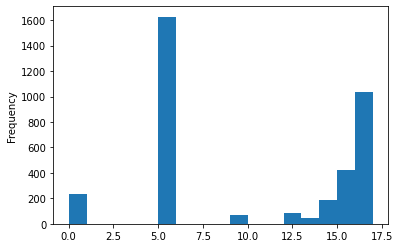

3470


In [ ]:
row_notna_count = df.notna().sum(axis=1)
row_notna_count.plot.hist(bins=row_notna_count.max())
plt.show()

df = df[row_notna_count >= 2]
print(len(df))

In [ ]:
model_name = "gogamza/kobart-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


count    36793.000000
mean        13.147582
std          6.909344
min          1.000000
25%          8.000000
50%         12.000000
75%         17.000000
max        318.000000
dtype: float64

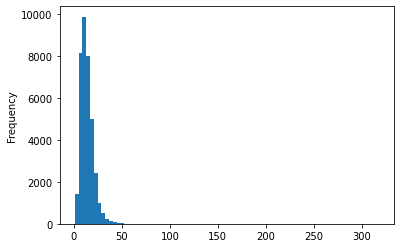

In [ ]:
lengths = []

for column in df.columns:
  out = tokenizer(df[column][df[column].notna()].tolist())
  out = [len(x) for x in out['input_ids']]
  lengths.extend(out)

lengths = pd.Series(lengths)
display(lengths.describe())
lengths.plot.hist(bins=80)

대부분 토큰의 길이가 50 이하

##### Dataset Class 만들기

In [ ]:
style_map = {
    'formal': '문어체',
    'informal': '구어체',
    'android': '안드로이드',
    'azae': '아재',
    'chat': '채팅',
    'choding': '초등학생',
    'emoticon': '이모티콘',
    'enfp': 'enfp',
    'gentle': '신사',
    'halbae': '할아버지',
    'halmae': '할머니',
    'joongding': '중학생',
    'king': '왕',
    'naruto': '나루토',
    'seonbi': '선비',
    'sosim': '소심한',
    'translator': '번역기'
}

In [ ]:
class TextStyleTransferDataset(Dataset):
  def __init__(self, 
               df: pd.DataFrame, 
               tokenizer: Tokenizer
               ):
    self.df = df
    self.tokenizer = tokenizer
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index, :].dropna().sample(2)
    text1 = row[0]
    text2 = row[1]
    target_style = row.index[1]
    target_style_name = style_map[target_style]

    encoder_text = f"{target_style_name} 말투 : {text1}"
    decoder_text = f"{text2}{self.tokenizer.eos_token}"
    model_inputs = self.tokenizer(encoder_text, max_length=64, truncation=True)

    with self.tokenizer.as_target_tokenizer():
      labels = tokenizer(decoder_text, max_length=64, truncation=True)
    model_inputs['labels'] = labels['input_ids']
    del model_inputs['token_type_ids']

    return model_inputs

In [ ]:
dataset = TextStyleTransferDataset(df, tokenizer)
out = dataset[0]
print(out['input_ids'])
print(out['labels'])
print(tokenizer.decode(out['input_ids']))
print(tokenizer.decode(out['labels']))

out = dataset[1]
print(out['input_ids'])
print(out['labels'])
print(tokenizer.decode(out['input_ids']))
print(tokenizer.decode(out['labels']))

[26988, 14070, 13282, 14987, 14042, 12053, 1223, 1223, 14054, 18646, 9036, 10397, 14195, 26832, 14947, 11914, 9754, 232]
[27616, 11478, 14495, 243, 243, 16530, 17849, 12034, 14195, 26832, 14947, 11922, 14562, 1]
신사 말투 : 하잉ᄏᄏ 나 떼걸룩 6마리 키운다!
안녕하십니까,, 저는 고양이 6마리 키웁니다.</s>
[17802, 14070, 13282, 14987, 17849, 15188, 14195, 10496, 24665, 22679, 11478, 27879, 14105, 14452, 9989, 11467, 15248, 243]
[16513, 9264, 10285, 16973, 10500, 14456, 14298, 14118, 22679, 9264, 14105, 15994, 9828, 262, 1]
할머니 말투 : 고양이를 6마리나 키우십니까? 안 힘드신지,,
니기럴 털만 날리는 거 키우기 안 힘들데?</s>


In [ ]:
from sklearn.model_selection import train_test_split

# train, test set
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
print(len(df_train), len(df_test))

3123 347


In [ ]:
train_dataset = TextStyleTransferDataset(
    df_train,
    tokenizer
)
test_dataset = TextStyleTransferDataset(
    df_test,
    tokenizer
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, model=model
)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [ ]:
model_path = "/content/drive/MyDrive/MemeProject/model/pytorch/text-transfer-smilegate-bart-eos/"

training_args = Seq2SeqTrainingArguments(
    output_dir=model_path, #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=24, # number of training epochs
    per_device_train_batch_size=16, # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    eval_steps=500, # Number of update steps between two evaluations.
    save_steps=1000, # after # steps model is saved 
    warmup_steps=300,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    evaluation_strategy="steps",
    save_total_limit=3
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3123
  Num Epochs = 24
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4704
  Number of trainable parameters = 123859968
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,2.676000,1.798954
1000,1.634400,1.672204
1500,1.375300,1.485984
2000,1.259600,1.607790
2500,1.139800,1.443281
3000,1.061300,1.481546
3500,1.004700,1.522701
4000,0.965400,1.390216
4500,0.924200,1.569652


***** Running Evaluation *****
  Num examples = 347
  Batch size = 16
***** Running Evaluation *****
  Num examples = 347
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/MemeProject/model/pytorch/text-transfer-smilegate-bart-eos/checkpoint-1000
Configuration saved in /content/drive/MyDrive/MemeProject/model/pytorch/text-transfer-smilegate-bart-eos/checkpoint-1000/config.json
Configuration saved in /content/drive/MyDrive/MemeProject/model/pytorch/text-transfer-smilegate-bart-eos/checkpoint-1000/generation_config.json
Model weights saved in /content/drive/MyDrive/MemeProject/model/pytorch/text-transfer-smilegate-bart-eos/checkpoint-1000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts

TrainOutput(global_step=4704, training_loss=1.3184637504370034, metrics={'train_runtime': 446.9373, 'train_samples_per_second': 167.701, 'train_steps_per_second': 10.525, 'total_flos': 1399897745326080.0, 'train_loss': 1.3184637504370034, 'epoch': 24.0})

In [ ]:
trainer.save_model()

Saving model checkpoint to /content/drive/MyDrive/MemeProject/model/pytorch/text-transfer-smilegate-bart-eos/
Configuration saved in /content/drive/MyDrive/MemeProject/model/pytorch/text-transfer-smilegate-bart-eos/config.json
Configuration saved in /content/drive/MyDrive/MemeProject/model/pytorch/text-transfer-smilegate-bart-eos/generation_config.json
Model weights saved in /content/drive/MyDrive/MemeProject/model/pytorch/text-transfer-smilegate-bart-eos/pytorch_model.bin


##### Pipeline을 이용해서 학습한 모델로 텍스트 생성해보기

In [ ]:
from transformers import pipeline

nlg_pipeline = pipeline('text2text-generation', model=model_path, tokenizer=model_name)

loading configuration file /content/drive/MyDrive/MemeProject/model/pytorch/text-transfer-smilegate-bart-eos/config.json
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Model config BartConfig {
  "_name_or_path": "/content/drive/MyDrive/MemeProject/model/pytorch/text-transfer-smilegate-bart-eos/",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encode

In [ ]:
def generate_text(pipe, text, target_style, num_return_sequences=5, max_length=60):
  target_style_name = style_map[target_style]
  text = f"{target_style_name} 말투 : {text}"
  out = pipe(text, num_return_sequences=num_return_sequences, max_length=max_length)
  return [x['generated_text'] for x in out]

In [ ]:
src_text = "어제 먹은 밥이 너무 맛있었어"

print("입력 문장:", src_text)

for style in df.columns:
  print(style, generate_text(nlg_pipeline, src_text, style, num_return_sequences=1, max_length=1000)[0])

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}



입력 문장: 어제 먹은 밥이 너무 맛있었어
formal 어제 먹은 밥이 너무 맛있었어요.


Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}



informal 어제 먹은 밥이 너무 맛있었어.
android 어제. 밥. 맛있음.


Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}



azae 어제 먹은 밥이 넘 맛있었어~
chat 어제 먹은 밥이 너무 맛있었음 ᄏᄏᄏᄏᄏ


Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}



choding 어제 먹은 밥이 넘 맛있었음
emoticon 어제 먹은 밥이 너무 맛있었어 (゚▽゚)ノ


Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}



enfp 어제 먹은 밥이 넘 맛있었엉 ᄒᄒ
gentle 어제 먹은 밥이 너무 맛있었습니다.


Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}



halbae 어제 먹은 밥이 너무 맛있었구먼...
halmae 어제 먹은 밥이 넘 맛있었어


Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}



joongding 어제 먹은 밥이 너무 맛있었음
king 어제 먹은 밥이 너무 맛있었소.


Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}



naruto 어제 먹은 밥이 너무 맛있었다니깐!
seonbi 어제 먹은 밥이 너무 맛있었소!


Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.1"
}



sosim 어제 먹은 밥이 너무 맛있었어..
translator 어제 먹은 밥은 너무 맛있었다.


# Text Style Transfer

##### 평균 미만 데이터 증강
##### data split by average

In [7]:
import sys
sys.path.append('/content/drive/MyDrive/MemeProject/src/pytorch/preprocessing')
print(sys.path)

['/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/MemeProject/src/pytorch/preprocessing']


In [8]:
from tqdm import tqdm
import config as cfg
import pandas as pd
import numpy as np
import swifter
from tqdm import tqdm
from pshmodule.utils import filemanager as fm

In [9]:
df_arg = fm.load(cfg.arg_aug_data)

extension : .pickle
Loaded 20462 records from drive/MyDrive/MemeProject/data/augmentation/arg_aug.pickle


In [10]:
df_arg.label.describe()

,label
count,20462.000000
mean,82.362917
std,46.729405
min,0.000000
25%,42.000000
50%,85.000000
75%,124.000000
max,152.000000


In [11]:
label_count = {i[1]['label']: 0 for i in df_arg.iterrows()}

for i in df_arg.iterrows():
  label_count[i[1]['label']] += 1

label_count = {k: v for k, v in sorted(label_count.items(), key=lambda x: x[1], reverse=True)}

82 이상

In [12]:
label_count_82_upper = {i[0]: i[1] for i in label_count.items() if i[1] >= 82}

In [13]:
label_count_82_upper.keys()

dict_keys([150, 152, 151, 149, 9, 109, 89, 142, 33, 101, 47, 41, 107, 120, 28, 133, 46, 143, 63, 18, 50, 92, 3, 57, 12, 13, 0, 118, 80, 59, 78, 127, 67, 75, 116, 73, 31, 96, 106, 144, 66, 81, 117, 135, 32, 64, 61, 95, 100, 91, 104, 128, 146, 42, 36, 48, 138, 147, 126, 58, 98, 85, 139, 68, 103, 94, 97, 53, 114, 17, 39, 145, 34, 10, 60, 21, 121, 16, 105, 137, 140, 131, 51, 25, 129, 45, 2, 14, 15, 102, 134, 52, 1, 72, 4, 37, 62, 74, 141, 115, 6])

In [14]:
arg_upper = [[i[1]['g_num'], i[1]['u_num'], i[1]['material'], i[1]['speech'], i[1]['u'], i[1]['arg'], i[1]['label']] for i in df_arg.iterrows() if i[1]['label'] in label_count_82_upper.keys()]

In [15]:
df_arg_upper = pd.DataFrame(arg_upper, columns=[['g_num', 'u_num', 'material', 'speech', 'u', 'arg', 'label']])

In [16]:
df_arg_upper.shape

(17756, 7)

82 미만

In [17]:
label_count_82_under = {i[0]: i[1] for i in label_count.items() if i[1] < 82}

In [18]:
label_count_82_under.keys()

dict_keys([87, 19, 136, 99, 54, 8, 20, 124, 49, 43, 27, 122, 71, 110, 65, 82, 108, 23, 40, 29, 26, 119, 125, 123, 70, 88, 44, 130, 93, 69, 84, 5, 38, 55, 113, 7, 22, 90, 79, 148, 76, 35, 132, 111, 11, 77, 86, 24, 56, 30, 112, 83])

In [19]:
arg_under = [[i[1]['g_num'], i[1]['u_num'], i[1]['material'], i[1]['speech'], i[1]['u'], i[1]['arg'], i[1]['label']] for i in df_arg.iterrows() if i[1]['label'] in label_count_82_under.keys()]

In [20]:
df_arg_under = pd.DataFrame(arg_under, columns=[['g_num', 'u_num', 'material', 'speech', 'u', 'arg', 'label']])

In [21]:
df_arg_under.shape

(2706, 7)

##### 문체 생성

In [34]:
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    pipeline,
)
from tokenizers import Tokenizer
from typing import Dict, List, Optional
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


from IPython.display import display
from typing import Dict

In [23]:
model_path = "/content/drive/MyDrive/MemeProject/model/pytorch/text-transfer-smilegate-bart-eos/"
model_name = "gogamza/kobart-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [24]:
nlg_pipeline = pipeline('text2text-generation', model=model_path, tokenizer=model_name)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [25]:
style_map = {
    'formal': '문어체',
    'informal': '구어체',
    'android': '안드로이드',
    'azae': '아재',
    'chat': '채팅',
    'choding': '초등학생',
    'emoticon': '이모티콘',
    'enfp': 'enfp',
    'gentle': '신사',
    'halbae': '할아버지',
    'halmae': '할머니',
    'joongding': '중학생',
    'king': '왕',
    'naruto': '나루토',
    'seonbi': '선비',
    'sosim': '소심한',
    'translator': '번역기'
}

def generate_text(pipe, text, target_style, num_return_sequences=5, max_length=60):
  target_style_name = style_map[target_style]
  text = f"{target_style_name} 말투 : {text}"
  out = pipe(text, num_return_sequences=num_return_sequences, max_length=max_length)
  return [x['generated_text'] for x in out]

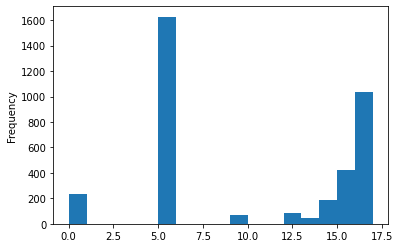

In [26]:
df = pd.read_csv("smilestyle_dataset.tsv", sep="\t")
row_notna_count = df.notna().sum(axis=1)
row_notna_count.plot.hist(bins=row_notna_count.max())

df = df[row_notna_count >= 2]

In [32]:
df_arg_under.head()

,g_num,u_num,material,speech,u,arg,label
0,19,1,미용,소망,나 올 여름엔 비키니 잘 어울리고 싶어,,49
1,19,2,미용,소망,나도 비키니 잘 소화하고 싶어,,49
2,19,3,미용,소망,여름에 비키니 소화해 보고 싶어!,,49
3,19,4,미용,소망,나도 비키니 잘 어울리면 좋겠다,,49
4,19,5,미용,소망,나도 비키니 소화 잘하고 싶어,,49


In [30]:
print(df_arg_upper.shape)
print(df_arg_under.shape)

(17756, 7)
(2706, 7)


In [ ]:
df_transform = []

for i in tqdm(df_arg_under.iterrows()):
  print(" ")
  print(f"입력 문장 : {i[1]['u']}")
  for style in df.columns:
    print(style, generate_text(nlg_pipeline, i, style, num_return_sequences=1, max_length=1000)[0])
    df_transform.append([i[1]['g_num'], i[1]['u_num'], i[1]['material'], i[1]['speech'], generate_text(nlg_pipeline, i[1]['u'], style, num_return_sequences=1, max_length=1000)[0], style, i[1]['arg'], i[1]['label']])

In [ ]:
pd.DataFrame(df_transform, columns=[['g_num', 'u_num', 'material', 'speech', 'u', 'style', 'arg', 'label']])

In [28]:
# src_text = "나 오늘 밤새 밖에서 놀 거야"
# print("입력 문장:", src_text)

# for style in df.columns:
#   print(style, generate_text(nlg_pipeline, src_text, style, num_return_sequences=1, max_length=1000)[0])

입력 문장: 나 오늘 밤새 밖에서 놀 거야
formal 저는 오늘 밤새 밖에서 놀고 있습니다.
informal 나는 오늘 밤새 밖에서 놀 거야.
android 안드로이드. 오늘. 밤. 밖. 놀 것.
azae 오늘 밤새 밖에서 놀거야~
chat 난 오늘 밤새 밖에서 놀거임
choding 오늘 밤새 밖에서 놀거임
emoticon 난 오늘 밤새 밖에서 놀 거야 (★‿★)
enfp 웅웅! 오늘 밤엔 밖에서 놀거!!
gentle 저는 오늘 밤새 밖에서 놀고 있습니다.
halbae 나는......오늘 밤은...자주 밖에서 놀 것이구먼...
halmae 오늘 밤새 밖에서 놀것네
joongding 난 오늘새에 놀거임
king 짐은 오늘 밤에는 밖에서 놀겠소.
naruto 난 오늘새에 밤새 밖에서 놀고 있다니깐!
seonbi 소생은 오늘 밤새 밖에서 놀 것이오!
sosim 난 오늘새에 밤새 밖에서 놀거야..
translator 나는 오늘 밤 늦게까지 밖에서 놀 예정이다.
